Content:<br>

   * [1. Resampling - dimensionality reductions](#resampl)
   * [2. Features extraction steps](#featuresextractionsteps)

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '../../')

from libs.utils import *
from libs.functions import *

In [3]:
train_audio_path = '../../../_inputs/raw/train/audio/'

In [4]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
# sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear.
We need to assure that there are no 0 values as input to logarithm.

## 1. Resampling - dimensionality reduction
<a id="resampl"></a> 

Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, [the most speech related frequencies are presented in smaller band](https://en.wikipedia.org/wiki/Voice_frequency). That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT (Fast Fourier Transform).


Let's read some recording, resample it, and listen. We can also compare FFT, Notice, that there is almost no information above 4000 Hz in original signal.

In [6]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [7]:
ipd.Audio(samples, rate=sample_rate)

In [8]:
ipd.Audio(resampled, rate=new_sample_rate)

Almost no difference!

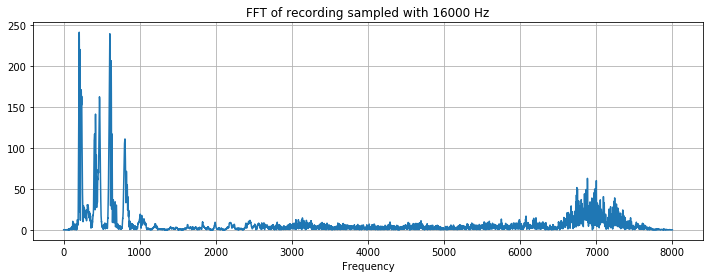

In [9]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

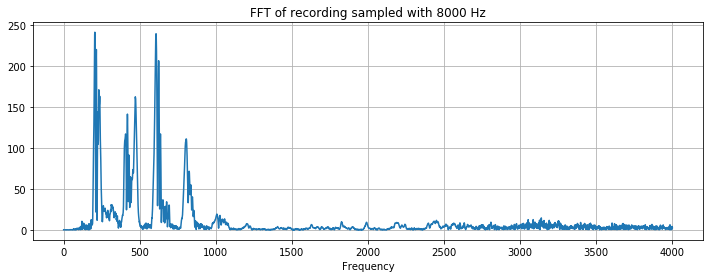

In [10]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

This is how we reduced dataset size twice!

## 2. Features extraction steps
<a id="featuresextractionsteps"></a> 

I would propose the feature extraction algorithm like that:
1. Resampling
2. *VAD*
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or *MFCC*, or *PLP*)
5. Features normalization with *mean* and *std*
6. Stacking of a given number of frames to get temporal information

It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.